In [3]:
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/hyperspectral-dataset/TASK-ML-INTERN.csv


In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import optuna

In [17]:
def load_data(file_path):
    df = pd.read_csv(path)
    return df

# Load dataset
df = load_data('/kaggle/input/mle-assignment/MLE-Assignment.csv')
df.head()

,hsi_id,0,1,2,3,4,5,6,7,8,...,439,440,441,442,443,444,445,446,447,vomitoxin_ppb
0,imagoai_corn_0,0.416181,0.396844,0.408985,0.372865,0.385293,0.365390,0.355226,0.343350,0.344837,...,0.710280,0.717482,0.715078,0.705379,0.696691,0.692793,0.711369,0.697679,0.704520,1100.0
1,imagoai_corn_1,0.415797,0.402956,0.402564,0.396014,0.397192,0.389634,0.375671,0.363689,0.373883,...,0.684011,0.697271,0.701995,0.696077,0.701012,0.677418,0.696921,0.696544,0.689054,1000.0
2,imagoai_corn_2,0.389023,0.371206,0.373098,0.373872,0.361056,0.349709,0.333882,0.330841,0.328925,...,0.683054,0.669286,0.663179,0.676165,0.676591,0.655951,0.658945,0.670989,0.665176,1300.0
3,imagoai_corn_3,0.468837,0.473255,0.462949,0.459335,0.461672,0.459824,0.458194,0.427737,0.415360,...,0.742782,0.730801,0.736787,0.730044,0.751437,0.738497,0.742446,0.754657,0.733474,1300.0
4,imagoai_corn_4,0.483352,0.487274,0.469153,0.487648,0.464026,0.451152,0.458229,0.440782,0.426193,...,0.770227,0.773013,0.761431,0.763488,0.762473,0.744012,0.775486,0.760431,0.751988,220.0


In [18]:
def preprocess_data(df, n_components=10):
    # Handle missing values
    imputer = SimpleImputer(strategy='mean')
    df.iloc[:, 1:-1] = imputer.fit_transform(df.iloc[:, 1:-1])
    
    # Normalize data
    scaler = StandardScaler()
    X = scaler.fit_transform(df.iloc[:, 1:-1])
    y = df.iloc[:, -1]

    # Apply PCA
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X)

    print(f"Explained Variance Ratio: {np.sum(pca.explained_variance_ratio_):.4f}")

    return X_pca, y, scaler, pca

X, y, scaler, pca = preprocess_data(df, n_components=10)

Explained Variance Ratio: 0.9664


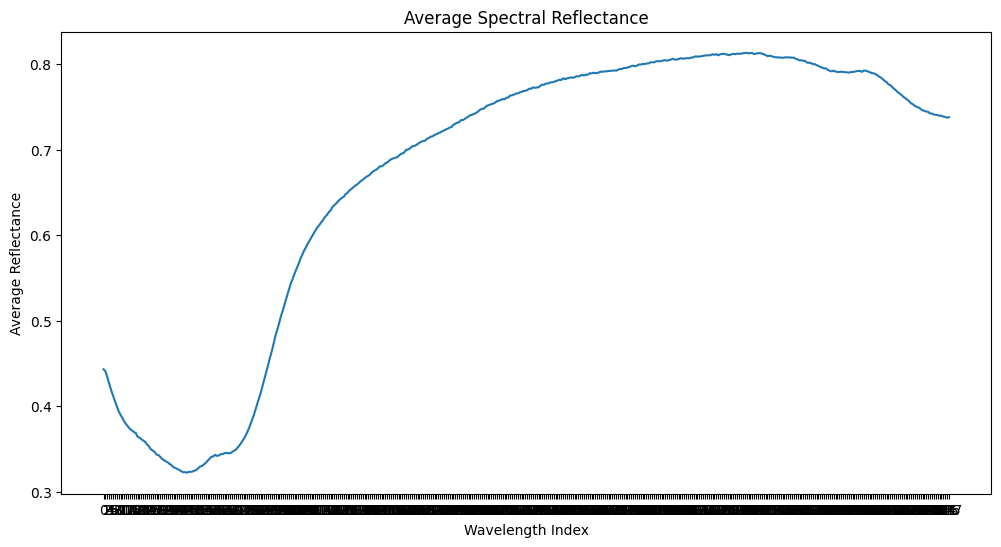

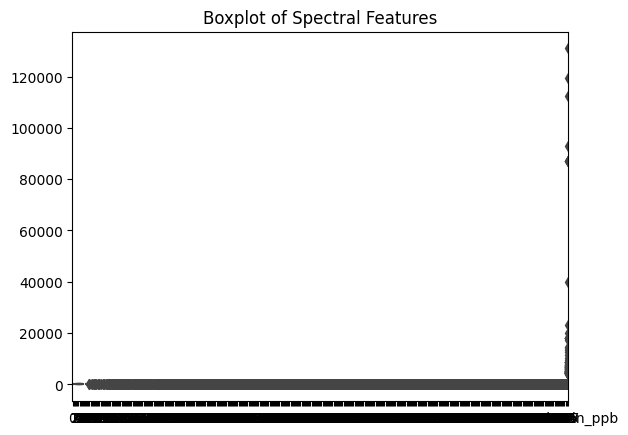

In [20]:
def visualize_data(df):
    plt.figure(figsize=(12, 6))
    plt.plot(df.iloc[:, 1:-1].mean(axis=0))
    plt.xlabel('Wavelength Index')
    plt.ylabel('Average Reflectance')
    plt.title('Average Spectral Reflectance')
    plt.show()

    sns.boxplot(data=df)
    plt.title('Boxplot of Spectral Features')
    plt.show()

visualize_data(df)

In [23]:
def train_model(X_train, y_train, X_test, y_test):
    model = MLPRegressor(hidden_layer_sizes=(64, 32), max_iter=500, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Evaluate model
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    print(f'MAE: {mae:.4f}, RMSE: {rmse:.4f}, R²: {r2:.4f}')
    return model

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = train_model(X_train, y_train, X_test, y_test)

MAE: 3788.1598, RMSE: 10575.2038, R²: 0.5999


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


In [24]:
def objective(trial):
    hidden_layers = trial.suggest_categorical('hidden_layer_sizes', [(64, 32), (128, 64), (256, 128)])
    learning_rate = trial.suggest_loguniform('learning_rate_init', 1e-4, 1e-2)

    model = MLPRegressor(hidden_layer_sizes=hidden_layers, learning_rate_init=learning_rate, max_iter=500, random_state=42)
    score = cross_val_score(model, X_train, y_train, cv=5, scoring='r2').mean()
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)
print(f'Best params: {study.best_params}')

[I 2025-03-16 18:39:11,640] A new study created in memory with name: no-name-c9fceef6-f9f6-49f3-bebe-09688e81a776
/usr/local/lib/python3.10/dist-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (64, 32) which is of type tuple.
  warnings.warn(message)
/usr/local/lib/python3.10/dist-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (128, 64) which is of type tuple.
  warnings.warn(message)
/usr/local/lib/python3.10/dist-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (256, 128) which is of type tuple.
  warnings.warn(message)
<ipython-input-24-aad9159bc0e5>:3: FutureWarning: suggest_loguniform has been depr

Best params: {'hidden_layer_sizes': (128, 64), 'learning_rate_init': 0.00019505865798078822}


Mean Absolute Error (MAE): 3788.1598
Root Mean Squared Error (RMSE): 10575.2038
R² Score: 0.5999


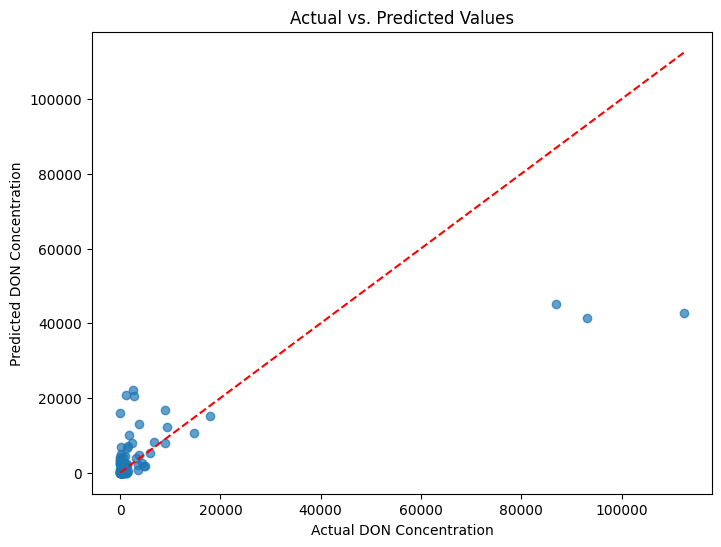

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


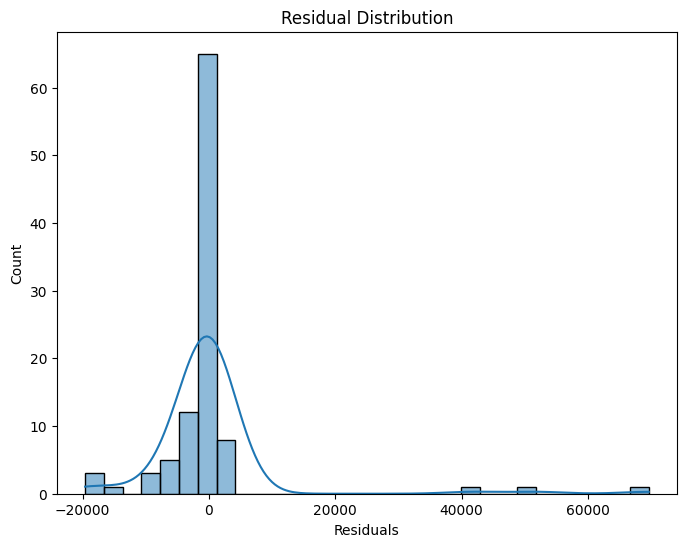

(3788.1598456402266, 10575.203768814874, 0.5999224079332729)

In [25]:
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)

    # Calculate evaluation metrics
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"R² Score: {r2:.4f}")

    # Scatter plot: Actual vs Predicted
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred, alpha=0.7)
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
    plt.xlabel("Actual DON Concentration")
    plt.ylabel("Predicted DON Concentration")
    plt.title("Actual vs. Predicted Values")
    plt.show()

    # Residual Analysis
    residuals = y_test - y_pred
    plt.figure(figsize=(8, 6))
    sns.histplot(residuals, kde=True, bins=30)
    plt.xlabel("Residuals")
    plt.title("Residual Distribution")
    plt.show()

    return mae, rmse, r2

# Run evaluation
evaluate_model(model, X_test, y_test)